In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings; warnings.filterwarnings('ignore')
import matplotlib.path as mpath

from functions import *

import sys; sys.path.append("..")
from dataset_manipulation import *
from palette import *
from plot import *

In [2]:
casealias = ['CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']
fig_folder = '../../figures/results/'
boreal_lat=50.
processed_output = '../../processed-data/output/'

In [3]:
## Create area file
"""fn_in='surfdata_1.9x2.5_hist_78pfts_CMIP6_simyr2000_c190304'
fn = '../../data/surfdatamap/'+fn_in + '.nc'
dset_in = xr.open_dataset(fn)
dset_in = convert_lsmcoord(dset_in)
dset_in = convert360_180(dset_in)
area = dset_in['AREA']*1e6 #from km2 to m2
area.attrs['units'] = 'm$^2$'
area.load().to_netcdf('../../processed-data/area.nc')"""

"""
land = load_dataset_dict('LAND', cases=['CTRL'])
area = land['CTRL']['area'].mean('time')
area = area*1e6 #from km2 to m2
area.attrs['units'] = 'm$^2$'
area.interpolate_na('lon').interpolate_na('lat').plot()"""

area = xr.open_dataset('../../processed-data/area.nc')
boreal_area = float(area['AREA'].where(area.lat>boreal_lat, drop=True).sum().values) #(2*np.pi*6371000**2)*(1-np.sin((np.deg2rad(boreal_lat)))) #6,371

In [4]:
def boreal_average(ds, variable, method = 'average', boreal_lat=50., area=None):
    
    da = ds[variable].where(ds[variable].lat>boreal_lat, drop=True)
    intensive_value = da.weighted(ds['gw']).mean(['lon','lat', 'time'])
    if variable=='ACTNL' or variable=='ACTREL':
        fctl = ds['FCTL'].where(ds['FCTL'].lat>boreal_lat, drop=True)
        fctl_value = fctl.weighted(ds['gw']).mean(['lon','lat', 'time'])
        intensive_value = intensive_value / fctl_value
    if variable == 'N_AER': intensive_value = intensive_value.isel(lev=-1)
    
    intensive_value = float(intensive_value.values)
    
    if method == 'cumulative':
        if not area:
            return intensive_value*(2*np.pi*6371000**2)*(1-np.sin((np.deg2rad(boreal_lat)))) #6378
        else:
            return intensive_value*area
    else: return intensive_value
#return float(ds[variable].weighted(ds['gw']).mean(['lon','lat', 'time']).values*5096000001e+6*1e-15) #*(4*np.pi*6357000**2))*12*1e-15
#return float(ds[variable].sum(['lon','lat']).mean('time').values*5096000001e+6*1e-15)

In [5]:
bvoc = load_dataset_dict('BVOC', boreal_lat = boreal_lat)

In [6]:
soa = load_dataset_dict('SOA', boreal_lat = boreal_lat)
soa = add_SOA_TOT(soa, casealias)

In [7]:
cloud = load_dataset_dict('CLOUDPROP', boreal_lat = boreal_lat)
for case in casealias:
    cloud[case] = fix_cloud(cloud[case])

In [8]:
radiative = load_dataset_dict('RADIATIVE', boreal_lat = boreal_lat)
for case in casealias:
    radiative[case] = fix_radiative_names(radiative[case])

Ghan's scomposition completed
Ghan's scomposition completed
Ghan's scomposition completed
Ghan's scomposition completed
Ghan's scomposition completed


In [9]:
et = load_dataset_dict('ET', boreal_lat=boreal_lat)
et = fix_et(et)
for case in casealias:
    et[case]['gw'] = radiative[case]['gw']
    et[case]['gw'] = (['time','lat'], radiative[case]['gw'].values)

In [10]:
def relative_differences(ds_dict, variable):

    diff_list = []
    for cases in [['IDEAL-ON', 'CTRL'], ['IDEAL-ON', 'IDEAL-OFF'], ['IDEAL-OFF', 'CTRL'], 
                  ['REAL-ON', 'CTRL'], ['REAL-ON', 'REAL-OFF'], ['REAL-OFF', 'CTRL']]:
        value1 = boreal_average(ds_dict[cases[0]], variable, area=boreal_area)
        value2 = boreal_average(ds_dict[cases[1]], variable, area=boreal_area)
        diff = (value1-value2)/value2#*100
        #print(cases, diff)
        diff_list.append(diff)
    return diff_list

def absolute_differences(ds_dict, variable):

    diff_list = []
    for cases in [['IDEAL-ON', 'CTRL'], ['IDEAL-ON', 'IDEAL-OFF'], ['IDEAL-OFF', 'CTRL'], 
                  ['REAL-ON', 'CTRL'], ['REAL-ON', 'REAL-OFF'], ['REAL-OFF', 'CTRL']]:
        value1 = boreal_average(ds_dict[cases[0]], variable, area=boreal_area)
        value2 = boreal_average(ds_dict[cases[1]], variable, area=boreal_area)
        diff = (value1-value2)
        #print(cases, diff)
        diff_list.append(diff)
    return diff_list

In [11]:
big_difference_table_soa_cloud = pd.DataFrame(columns = [],
        index = ['IDEAL-ON - CTRL', 'IDEAL-ON - IDEAL-OFF', 'IDEAL-OFF - CTRL', 
                 'REAL-ON - CTRL', 'REAL-ON - REAL-OFF', 'REAL-OFF - CTRL'])

for i, ds_dict in enumerate([bvoc, soa, cloud]):
    if i ==0 : variables = ['SFisoprene', 'SFmonoterp']
    if i==1: variables = ['cb_SOA_TOT', 'N_AER']#, 'DOD550']
    if i==2: variables = ['ACTNL', 'ACTREL']#, 'TGCLDLWP']

    for variable in variables:

        diff_list = relative_differences(ds_dict, variable)
        big_difference_table_soa_cloud[variable] = ["{:.2%}".format(diff) for diff in diff_list]
        
big_difference_table_soa_cloud.to_csv(processed_output+'borealaverages_bvoc_soa_cloud.csv')
big_difference_table_soa_cloud

,SFisoprene,SFmonoterp,cb_SOA_TOT,N_AER,ACTNL,ACTREL
IDEAL-ON - CTRL,5.65%,0.88%,1.03%,0.28%,0.28%,-0.03%
IDEAL-ON - IDEAL-OFF,7.15%,1.93%,-0.33%,-0.30%,-0.93%,0.15%
IDEAL-OFF - CTRL,-1.41%,-1.04%,1.37%,0.59%,1.22%,-0.18%
REAL-ON - CTRL,4.57%,3.43%,2.53%,0.61%,-0.10%,-0.06%
REAL-ON - REAL-OFF,6.06%,4.51%,1.61%,-0.18%,-1.00%,0.09%
REAL-OFF - CTRL,-1.41%,-1.04%,0.90%,0.79%,0.90%,-0.15%


In [12]:
big_difference_table_radiative = pd.DataFrame(columns = [],
        index = ['IDEAL-ON - CTRL', 'IDEAL-ON - IDEAL-OFF', 'IDEAL-OFF - CTRL', 
                 'REAL-ON - CTRL', 'REAL-ON - REAL-OFF', 'REAL-OFF - CTRL'])

for variable in ['FTOT', 'DIR', 'NCFT','FREST']:

    diff_list = absolute_differences(radiative, variable)
    if variable=='FTOT': title = r'$F_{tot}$'
    elif variable=='DIR': title = r'$F_{dir}$'
    elif variable=='NCFT': title = r'$F_{cloud}$'
    elif variable=='FREST': title = r'$F_{rest}$'
    big_difference_table_radiative[title+r" $(W/m^2)$"] = ["{:.3f}".format(diff) for diff in diff_list]
big_difference_table_radiative.to_csv(processed_output+'borealaverages_radiative.csv')
big_difference_table_radiative

,$F_{tot}$ $(W/m^2)$,$F_{dir}$ $(W/m^2)$,$F_{cloud}$ $(W/m^2)$,$F_{rest}$ $(W/m^2)$
IDEAL-ON - CTRL,0.126,-0.002,-0.137,0.264
IDEAL-ON - IDEAL-OFF,0.023,-0.007,0.045,-0.015
IDEAL-OFF - CTRL,0.103,0.005,-0.182,0.279
REAL-ON - CTRL,0.430,-0.016,0.100,0.345
REAL-ON - REAL-OFF,0.011,-0.003,0.049,-0.035
REAL-OFF - CTRL,0.419,-0.013,0.051,0.380


In [13]:
for case in casealias:
    et[case] = et[case]*1000 # change unit 

big_difference_table_albedo_et = pd.DataFrame(columns = [],
        index = ['IDEAL-ON - CTRL', 'IDEAL-ON - IDEAL-OFF', 'IDEAL-OFF - CTRL', 
                 'REAL-ON - CTRL', 'REAL-ON - REAL-OFF', 'REAL-OFF - CTRL'])

for variable in ['SW_rest', 'QFLX_EVAP_TOT']:
    if variable == 'SW_rest': ds = radiative; units = r" $W/m^2$"
    if variable == 'QFLX_EVAP_TOT': ds = et; units = r"$\times 10^{-3}$ mm/day"  
    diff_list = absolute_differences(ds, variable)
    big_difference_table_albedo_et[variable+' abs'] = ["{:.3f} ".format(diff)+units for diff in diff_list]
    if variable == 'QFLX_EVAP_TOT': 
        big_difference_table_albedo_et[variable+' abs'] = ["{:.2f} ".format(diff)+units for diff in diff_list]
    diff_list = relative_differences(ds, variable)
    big_difference_table_albedo_et[variable+' rel'] = ["{:.2%}".format(diff) for diff in diff_list]

big_difference_table_albedo_et.to_csv(processed_output+'borealaverages_albedo_et.csv')
big_difference_table_albedo_et

,SW_rest abs,SW_rest rel,QFLX_EVAP_TOT abs,QFLX_EVAP_TOT rel
IDEAL-ON - CTRL,0.328 $W/m^2$,0.19%,6.43 $\times 10^{-3}$ mm/day,0.95%
IDEAL-ON - IDEAL-OFF,0.013 $W/m^2$,0.01%,1.46 $\times 10^{-3}$ mm/day,0.21%
IDEAL-OFF - CTRL,0.315 $W/m^2$,0.19%,4.97 $\times 10^{-3}$ mm/day,0.74%
REAL-ON - CTRL,0.480 $W/m^2$,0.28%,5.44 $\times 10^{-3}$ mm/day,0.81%
REAL-ON - REAL-OFF,-0.001 $W/m^2$,-0.00%,1.09 $\times 10^{-3}$ mm/day,0.16%
REAL-OFF - CTRL,0.480 $W/m^2$,0.29%,4.35 $\times 10^{-3}$ mm/day,0.64%


In [14]:
big_difference_table_albedo_et

,SW_rest abs,SW_rest rel,QFLX_EVAP_TOT abs,QFLX_EVAP_TOT rel
IDEAL-ON - CTRL,0.328 $W/m^2$,0.19%,6.43 $\times 10^{-3}$ mm/day,0.95%
IDEAL-ON - IDEAL-OFF,0.013 $W/m^2$,0.01%,1.46 $\times 10^{-3}$ mm/day,0.21%
IDEAL-OFF - CTRL,0.315 $W/m^2$,0.19%,4.97 $\times 10^{-3}$ mm/day,0.74%
REAL-ON - CTRL,0.480 $W/m^2$,0.28%,5.44 $\times 10^{-3}$ mm/day,0.81%
REAL-ON - REAL-OFF,-0.001 $W/m^2$,-0.00%,1.09 $\times 10^{-3}$ mm/day,0.16%
REAL-OFF - CTRL,0.480 $W/m^2$,0.29%,4.35 $\times 10^{-3}$ mm/day,0.64%


In [44]:
for variable in ['FTOT', 'FSNT', 'FLNT', 'DIR', 'NCFT', 'SWCF', 'LWCF', 'FREST', 'SW_rest', 'LW_rest']:
    for i, cases in enumerate([['IDEAL-ON', 'CTRL'], ['REAL-ON', 'CTRL'], ['IDEAL-ON', 'IDEAL-OFF'], 
                                   ['REAL-ON', 'REAL-OFF'], ['IDEAL-OFF', 'CTRL'], ['REAL-OFF', 'CTRL']]):
        print(variable, cases, ': ', boreal_average(radiative[cases[0]], variable)- boreal_average(radiative[cases[1]], variable))

FTOT ['IDEAL-ON', 'CTRL'] :  0.18995359289601765
FTOT ['REAL-ON', 'CTRL'] :  0.6035872712855621
FTOT ['IDEAL-ON', 'IDEAL-OFF'] :  0.03760630737832571
FTOT ['REAL-ON', 'REAL-OFF'] :  0.04964947297372646
FTOT ['IDEAL-OFF', 'CTRL'] :  0.15234728551769194
FTOT ['REAL-OFF', 'CTRL'] :  0.5539377983118356
FSNT ['IDEAL-ON', 'CTRL'] :  0.15775858136275644
FSNT ['REAL-ON', 'CTRL'] :  0.5167603565756451
FSNT ['IDEAL-ON', 'IDEAL-OFF'] :  0.030216683662217747
FSNT ['REAL-ON', 'REAL-OFF'] :  0.03043277326359828
FSNT ['IDEAL-OFF', 'CTRL'] :  0.1275418977005387
FSNT ['REAL-OFF', 'CTRL'] :  0.48632758331204684
FLNT ['IDEAL-ON', 'CTRL'] :  0.03219504277754481
FLNT ['REAL-ON', 'CTRL'] :  0.0868269385380529
FLNT ['IDEAL-ON', 'IDEAL-OFF'] :  0.0073895993840551455
FLNT ['REAL-ON', 'REAL-OFF'] :  0.019216694981935234
FLNT ['IDEAL-OFF', 'CTRL'] :  0.024805443393489668
FLNT ['REAL-OFF', 'CTRL'] :  0.06761024355611767
DIR ['IDEAL-ON', 'CTRL'] :  -0.0018771682319774774
DIR ['REAL-ON', 'CTRL'] :  -0.0157507307147

In [294]:
variable = 'SFisoprene'
print(variable)

for i, case in enumerate(casealias):
    if case == 'IDEAL-OFF' or case =='REAL-OFF':
        diff = (value - boreal_cumulative(bvoc[case], variable, area=boreal_area))*100
        print(diff/value)
    value = boreal_cumulative(bvoc[case], variable, area=boreal_area)
    print(case, ': ', value)
    
for i, case in enumerate(['IDEAL-ON', 'CTRL', 'REAL-ON', 'CTRL']):
    if case == 'CTRL':
        diff = value - boreal_cumulative(bvoc[case], 'SFisoprene', area=boreal_area)
    value = boreal_cumulative(bvoc[case], 'SFisoprene', area=boreal_area)
    print('SFisoprene', case, ': ', value)
    print(diff/value)

SFisoprene
CTRL :  9202892340782776.0
IDEAL-ON :  9722460365155860.0
6.67534224745958
IDEAL-OFF :  9073452860908098.0
REAL-ON :  9623449073256542.0
5.7151672769472786
REAL-OFF :  9073452860908098.0
SFisoprene IDEAL-ON :  9722460365155860.0
5.656965332762527
SFisoprene CTRL :  9202892340782776.0
0.05645703602014438
SFisoprene REAL-ON :  9623449073256542.0
0.053989793099955996
SFisoprene CTRL :  9202892340782776.0
0.04569832145162251


In [303]:
big_difference_table = pd.DataFrame(columns = [],
        index = ['IDEAL-ON – CTRL', 'IDEAL-ON – IDEAL-OFF', 'IDEAL-OFF – CTRL', 
                 'REAL-ON – CTRL', 'REAL-ON – REAL-OFF', 'REAL-OFF – CTRL'])
big_difference_table

""
IDEAL-ON – CTRL
IDEAL-ON – IDEAL-OFF
IDEAL-OFF – CTRL
REAL-ON – CTRL
REAL-ON – REAL-OFF
REAL-OFF – CTRL


In [310]:
def relative_differences(ds_dict, variable):

    diff_list = []
    for cases in [['IDEAL-ON', 'CTRL'], ['IDEAL-ON', 'IDEAL-OFF'], ['IDEAL-OFF', 'CTRL'], 
                  ['REAL-ON', 'CTRL'], ['REAL-ON', 'REAL-OFF'], ['REAL-OFF', 'CTRL']]:
        value1 = boreal_cumulative(ds_dict[cases[0]], variable, area=boreal_area)
        value2 = boreal_cumulative(ds_dict[cases[1]], variable, area=boreal_area)
        diff = (value1-value2)/value2#*100
        print(cases, diff)
        diff_list.append(diff)
    return diff_list

diff_list = relative_differences(bvoc, 'SFisoprene')
big_difference_table['SFisoprene'] = ["{:.2%}".format(diff) for diff in diff_list]

['IDEAL-ON', 'CTRL'] 0.05645703602014438
['IDEAL-ON', 'IDEAL-OFF'] 0.07152817281323347
['IDEAL-OFF', 'CTRL'] -0.014065086831567583
['REAL-ON', 'CTRL'] 0.04569832145162251
['REAL-ON', 'REAL-OFF'] 0.06061597726682836
['REAL-OFF', 'CTRL'] -0.014065086831567583


In [311]:
big_difference_table['SFisoprene'] = ["{:.2%}".format(diff) for diff in diff_list]

In [313]:
big_difference_table.T

,IDEAL-ON – CTRL,IDEAL-ON – IDEAL-OFF,IDEAL-OFF – CTRL,REAL-ON – CTRL,REAL-ON – REAL-OFF,REAL-OFF – CTRL
SFisoprene,5.65%,7.15%,-1.41%,4.57%,6.06%,-1.41%


In [284]:
for case in casealias:
    print('SFmonoterp', case, ': ',boreal_cumulative(bvoc[case], 'SFmonoterp', area=boreal_area))

SFmonoterp CTRL :  7500079868774061.0
SFmonoterp IDEAL-ON :  7565910856076755.0
SFmonoterp IDEAL-OFF :  7422418290078187.0
SFmonoterp REAL-ON :  7757494673359416.0
SFmonoterp REAL-OFF :  7422418290078187.0


In [111]:
def boreal_barplot(ds_dict, variable, title, ylim = None, method = 'average', boreal_lat=50., boreal_area=None, units=None):
    
    da = ds_dict['CTRL'][variable]
    
    if variable.startswith('SF'): method = 'cumulative'; units = 'Tg/y'
    if variable.startswith('cb'): method = 'cumulative'; units = 'mg'
        
    df = pd.DataFrame([['CTRL', boreal_average(ds_dict['CTRL'], variable, method = method), 0.], 
                   ['IDEAL', boreal_average(ds_dict['IDEAL-ON'], variable, method = method), boreal_average(ds_dict['IDEAL-OFF'], variable, method = method)], 
                   ['REAL', boreal_average(ds_dict['REAL-ON'], variable, method = method), boreal_average(ds_dict['REAL-OFF'], variable, method = method)]],
                  columns=['Run', 'ON', 'OFF'])

    if variable.startswith('SF'): df.iloc[:,1:3] = df.iloc[:,1:3].values*1e-15

    fig, ax = plt.subplots(1,1,figsize=[7,6.7])
    df.plot.bar(x='Run', layout='constrained', ax=ax, color=[['navy','g', 'g'],['y','y','y']],
            stacked=False, zorder=0, title=title)
    
        
    if not units: units = da.units
    
    plt.ylabel(da.long_name+'\n['+units+']')#'isoprene surface flux [kg/y]')
    plt.xlabel('')
    #plt.xticks(None)
    if ylim: plt.ylim(0, ylim)
    plt.xticks(rotation=0)#, ha="right")
    plt.legend(loc='upper left',title = 'Interactive BVOC')
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('g')
    plt.grid(linestyle='--', axis='y', alpha=0.5, zorder=1)
    plt.tight_layout()
    return fig

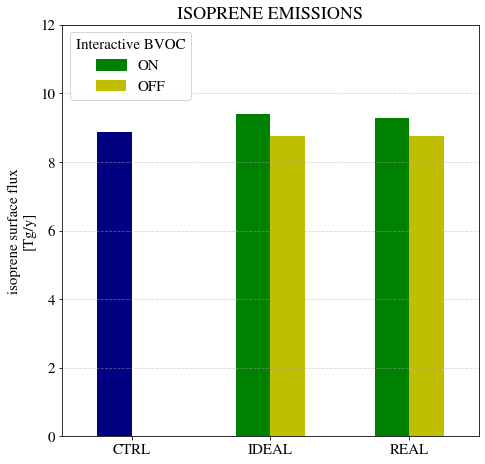

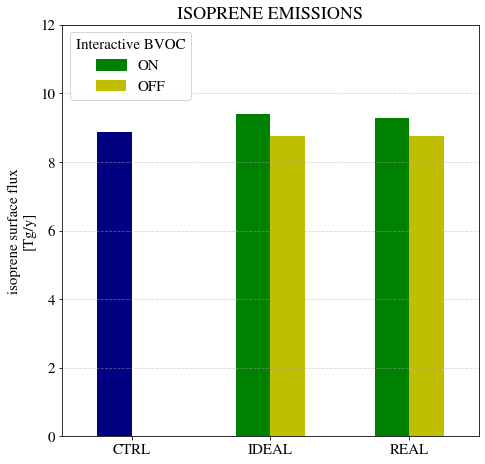

In [112]:
boreal_barplot(bvoc, 'SFisoprene', 'ISOPRENE EMISSIONS', ylim = 12)#1.2*1e16)

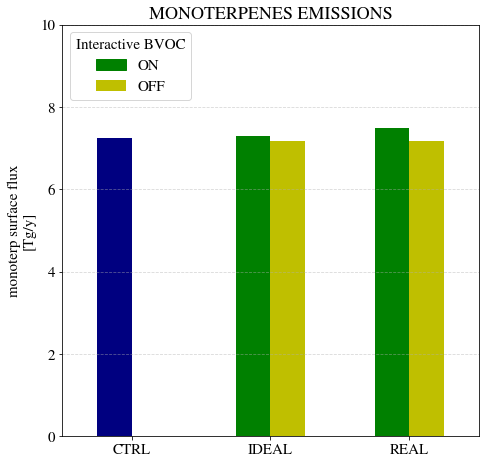

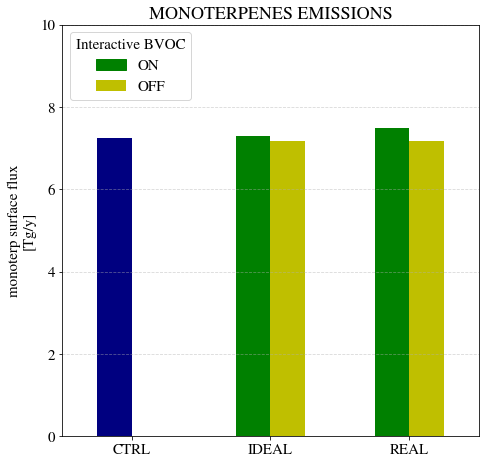

In [113]:
boreal_barplot(bvoc, 'SFmonoterp', 'MONOTERPENES EMISSIONS', ylim = 10)#1e16)

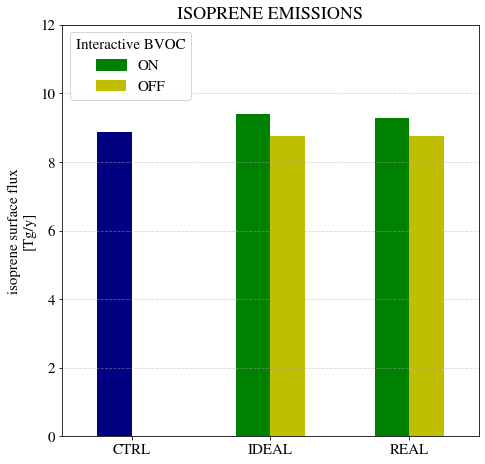

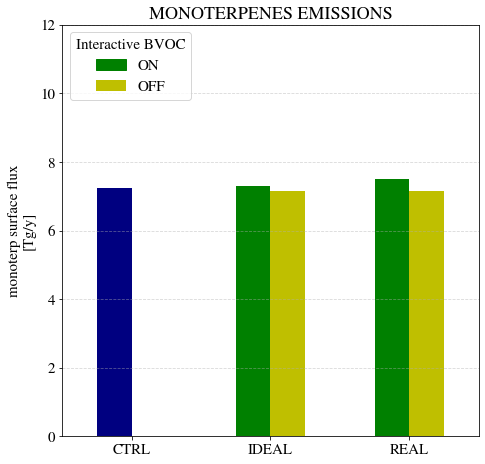

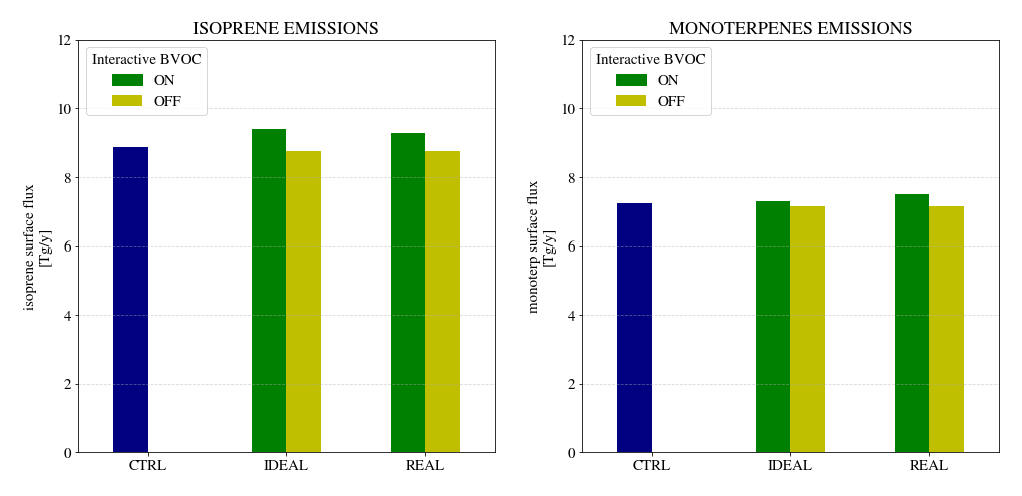

In [114]:
backend = mpl.get_backend()
mpl.use('agg')

figs = []
fig = boreal_barplot(bvoc, 'SFisoprene', 'ISOPRENE EMISSIONS', ylim = 12)
figs.append(fig)
fig = boreal_barplot(bvoc, 'SFmonoterp', 'MONOTERPENES EMISSIONS', ylim = 12)
figs.append(fig)

a_list = []
for fig in figs:
    c = fig.canvas
    c.draw()
    a_list.append(np.array(c.buffer_rgba()))

a = np.hstack(a_list)

mpl.use(backend)
fig,ax = plt.subplots(figsize=[14,7])
fig.subplots_adjust(0, 0, 1, 1)
ax.set_axis_off()
ax.matshow(a)
figtitle = fig_folder+'barplot_bvoc'
plt.savefig(figtitle+'.pdf')
plt.show()

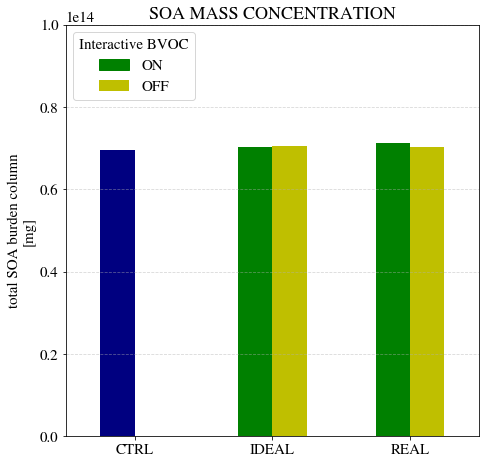

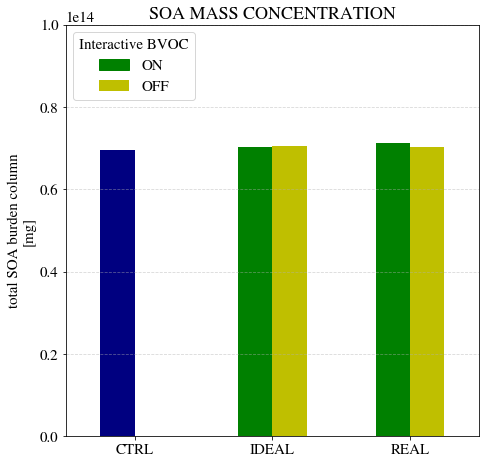

In [115]:
boreal_barplot(soa, 'cb_SOA_TOT', 'SOA MASS CONCENTRATION', ylim=1e14)

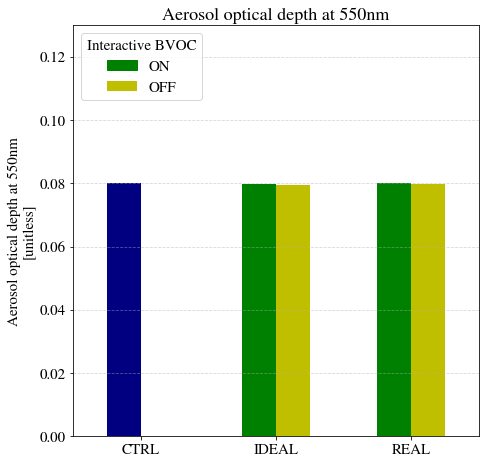

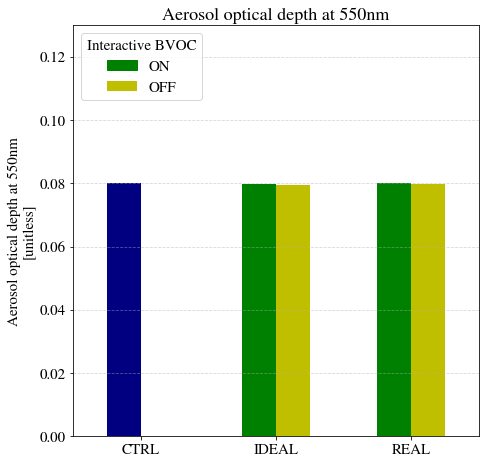

In [116]:
boreal_barplot(soa, 'DOD550', 'Aerosol optical depth at 550nm', ylim=0.13)

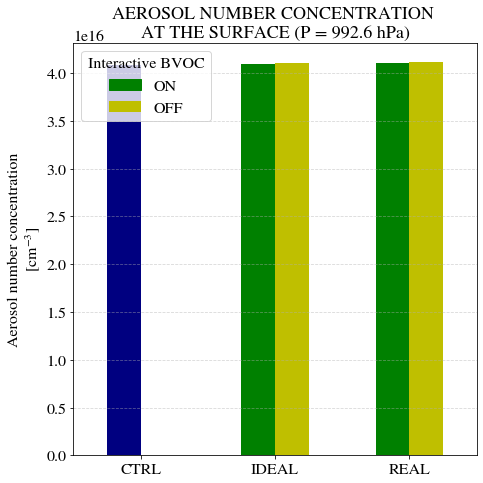

In [275]:
ds=soa
variable = 'N_AER'
title = 'AEROSOL NUMBER CONCENTRATION \nAT THE SURFACE (P = 992.6 hPa)'
boreal_barplot(ds, variable, title, ylim=900)

In [ ]:
cloud = load_dataset_dict('CLOUDPROP')

def fix_cloud(ds):
    
    ds_ = ds.copy(deep=True)
    
    for var in list(ds_.keys()):
            
        if var == "ACTNL":
            ds_[var].values = ds_[var].values*1e-12
        else:
            continue
        return ds_
    
for case in casealias:
    cloud[case] = fix_cloud(cloud[case])

     Run           ON          OFF
0   CTRL  1391.969414     0.000000
1  IDEAL  1470.555882  1372.391244
2   REAL  1455.580080  1372.391244


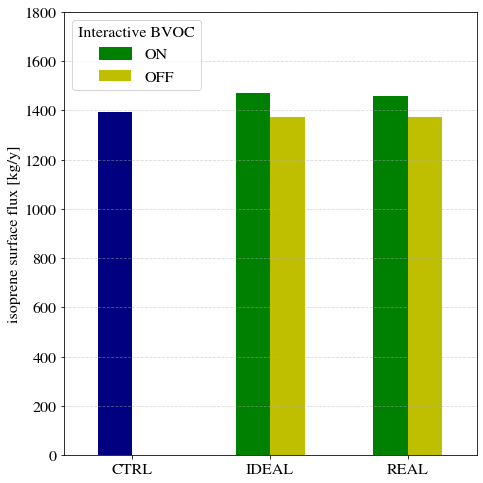

In [173]:
df = pd.DataFrame([['CTRL', global_average(bvoc['CTRL'], 'SFisoprene'), 0.], 
                   ['IDEAL', global_average(bvoc['IDEAL-ON'], 'SFisoprene'), global_average(bvoc['IDEAL-OFF'], 'SFisoprene')], 
                   ['REAL', global_average(bvoc['REAL-ON'], 'SFisoprene'), global_average(bvoc['REAL-OFF'], 'SFisoprene')]],
                  columns=['Run', 'ON', 'OFF'])
# view data
print(df)
  
# plot grouped bar chart
p = df.plot.bar(x='Run', layout='constrained', figsize=[7,7], color=[['navy','g', 'g'],['y','y','y']],
        stacked=False, zorder=0,
        title='')
plt.ylabel('isoprene surface flux [kg/y]')
plt.xlabel('')
#plt.xticks(None)
plt.ylim(0,1800)
plt.xticks(rotation=0)#, ha="right")
plt.legend(loc='upper left',title = 'Interactive BVOC')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('g')
plt.grid(linestyle='--', axis='y', alpha=0.5, zorder=1)
plt.tight_layout()

In [66]:
p

TypeError: 'method' object is not subscriptable

In [52]:
df.plot?


In [12]:
print(mpl.__version__)

3.3.2


In [57]:
df.index.get_level_values(1).unique()

Index(['ON', 'OFF'], dtype='object', name='BVOC')

<AxesSubplot:xlabel='time'>

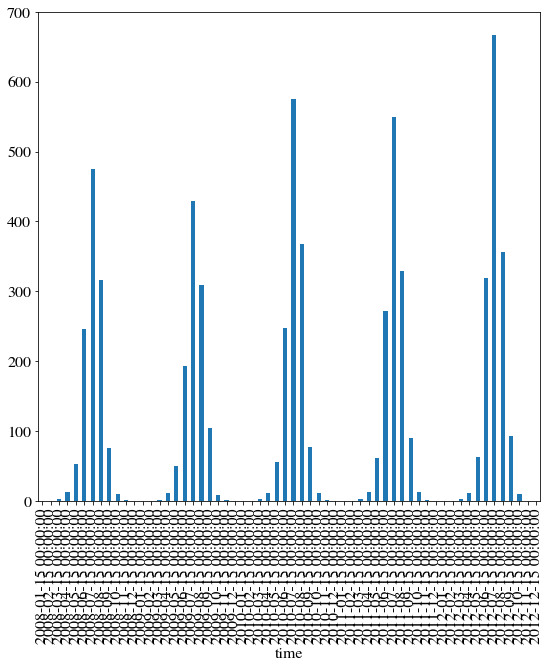

In [7]:
fig, ax = plt.subplots(figsize=(9, 9))
series = bvoc['CTRL']['SFisoprene'].weimean(('lat', 'lon')).to_series()
series.plot.bar(ax=ax)

In [ ]:
print (y.unstack(fill_value=0))
      Chevrolet  Dodge  Ford
1991          1      0     1
1992          2      2     1
1993          3      2     2
1994          0      3     2

y = vl.groupby(['Model Year','Manufacturer']).size()
y.unstack(fill_value=0).plot.bar(width=0.1, align='center')

plt.show()